## Package Imports

In [497]:
import matplotlib.pyplot as plt 


from Lilygo.Recording import Recording, data_integrity
from Lilygo.Dataset import Dataset

from scipy import signal
from scipy.fft import fftshift
import numpy as np
from math import sqrt
from scipy.fft import fft
from scipy.signal import medfilt
import pandas as pd
import glob
import os
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.svm import SVC 
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, LabelEncoder
from tqdm.notebook import tqdm_notebook
import json
import pickle

In [163]:
def data_analysis(recordings_folder_path):
    for i in range(1):
        sample = os.listdir(recordings_folder_path)[i]
        with open(os.path.join(recordings_folder_path, sample)) as sample_json:
            labelled_sample = json.load(sample_json)
        # print("Data Labels:", labelled_sample["labels"])
        # print(
            # "Data Fields:\n", labelled_sample["data"][0].keys()
        # )  # Zero'th element because "data" field is a list containing a dictionary of values {[]}

        field_lengths = dict.fromkeys(
            labelled_sample["data"][0].keys(),
        )
        for key in field_lengths.keys():
            if (type(labelled_sample["data"][0][key]) is not int) and (
                type(labelled_sample["data"][0][key]) is not float
            ):
                field_lengths[key] = len(labelled_sample["data"][0][key])
            else:
                field_lengths[key] = 1
        print("\nNumber of entries per field:", field_lengths)

    for i in range(len(os.listdir(recordings_folder_path))):
        sample = os.path.join(recordings_folder_path,os.listdir(recordings_folder_path)[i])
        trace = Recording(sample, no_labels=False, mute=True)
        print(trace.labels)
        


## Board Location 

In [105]:
def get_mag(trace, x, y, z):
    assert(x in trace.data and y in trace.data and z in trace.data)
    assert(len(trace.data[x].values) == len(trace.data[y].values) and len(trace.data[x].values) == len(trace.data[z].values))
    magn = [sqrt(a**2+trace.data[y].values[i]**2+trace.data[z].values[i]**2)for i, a in enumerate(trace.data[x].values)]
    return magn


def rolling_window_stride(array, window_size,freq):
    shape = (array.shape[0] - window_size + 1, window_size)
    strides = (array.strides[0],) + array.strides
    rolled = np.lib.stride_tricks.as_strided(array, shape=shape, strides=strides)
    return rolled[np.arange(0,shape[0],freq)]

def powerSpectrum(x, magn, thresh, filt_order, cutoff, band_type, title, xlim, ylim):
    #plt.close()
    Fs = int(x.samplerate)
    t = np.arange(0, x.total_time, 1/x.samplerate)
    # print(t)
    gated_magn = [0 if i < thresh else i for i in magn]

    butterworth = signal.butter(N = filt_order, Wn = cutoff, btype = band_type, output = "sos", fs = Fs)
    filt_magn = signal.sosfilt(butterworth, magn)

    #powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(filt_magn, Fs=Fs, NFFT = 256, noverlap = 128, pad_to = 256)
    powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(filt_magn, Fs=Fs, NFFT = 32, noverlap = 8, pad_to = 32)

    return powerSpectrum

In [484]:
def feature_extractor(filename):
    trace = Recording(filename, no_labels=False, mute=True)
    ax = trace.data["ax"]
    amagn = get_mag(trace, 'ax', 'ay', 'az')
    trace.data['amagn'] = Dataset.fromLists('Accelerometer magnitude', amagn, trace.data['ax'].timestamps)

    amagnar = np.asarray(amagn)
    windows = rolling_window_stride(amagnar, 200, 100)
    

    perc75 = 0
    iqr = 0
    rms = 0
    
    for i in range(len(windows)):
        perc75 = perc75 + np.percentile(windows[i],75)
        iqr = iqr + np.percentile(windows[i],75) - np.percentile(windows[i],25)
        rms = rms + np.sqrt(np.mean(windows[i]**2))
 
    perc75 = perc75/np.shape(windows)[0]
    iqr = iqr/np.shape(windows)[0]
    rms = rms/np.shape(windows)[0]
    

    PS = powerSpectrum(ax, amagn, 1.1, 20, 10, "lowpass", "Acc Mag", "std", 1)

    pss  = PS.mean(1)
    pss.flatten()    
    features = np.concatenate((np.array([perc75,iqr,rms]),pss))
    features.flatten()

    # print(features.shape)
   
    return features


def features_and_labels_constructor(data_folder_path: str):
    num_samples = len(os.listdir(data_folder_path))
    feature_matrix = np.zeros((num_samples,20)) # Create Matrix of Row Number: Num Samples; Col Number: 20
    label_vector = np.zeros((num_samples,1))
    for idx in tqdm_notebook(range(len(os.listdir(data_folder_path)))):
        filepath = data_folder_path + "/" + os.listdir(data_folder_path)[idx]
        feature_matrix[idx] = feature_extractor(filepath)
        trace = Recording(filepath, no_labels=False, mute=True)
        label_vector[idx] = trace.labels["board_loc"]
    
    print(feature_matrix.shape)
    return feature_matrix, label_vector


In [121]:
# print(feature_extractor("./data/pathdetection/group15_trace01.json"))



  0%|          | 0/167 [00:00<?, ?it/s]

(167, 20)


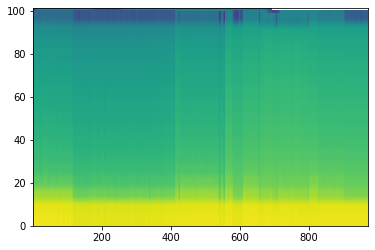

In [486]:
X_board, y_board  = features_and_labels_constructor("./data/mHealth_Ex2_Data")



In [95]:
# X = np.delete(X, 27)
# y = np.delete(y, 27)

In [487]:
def train_board_loc_classifier(model, X, y):
    kfolder = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)
    idx = 0
    for train_idx, test_idx in kfolder.split(X,y):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print("Confusion Matrix Fold %d: %s"%(idx, confusion_matrix(y_test, y_pred)))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        print("Number of Samples to be classified")
        print("Number of correct classifications %d: %f"%(idx, accuracy_score(y_test, y_pred, normalize = True)))
        plt.show()
        idx +=1

Confusion Matrix Fold 0: [[10  1  0]
 [ 3  8  0]
 [ 1  0 11]]
Number of Samples to be classified
Number of correct classifications 0: 0.852941


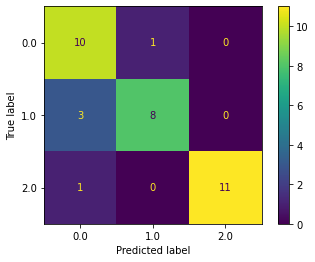

Confusion Matrix Fold 1: [[10  1  1]
 [ 1 10  0]
 [ 0  0 11]]
Number of Samples to be classified
Number of correct classifications 1: 0.911765


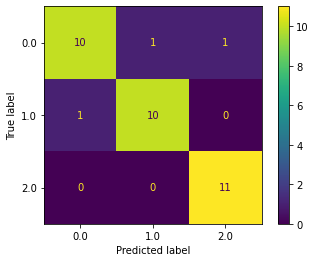

Confusion Matrix Fold 2: [[ 7  1  3]
 [ 2  9  0]
 [ 0  0 11]]
Number of Samples to be classified
Number of correct classifications 2: 0.818182


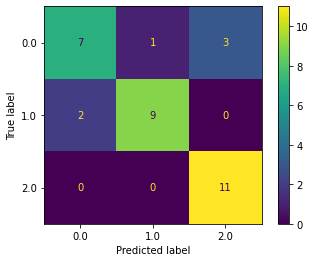

Confusion Matrix Fold 3: [[9 0 2]
 [1 9 1]
 [1 1 9]]
Number of Samples to be classified
Number of correct classifications 3: 0.818182


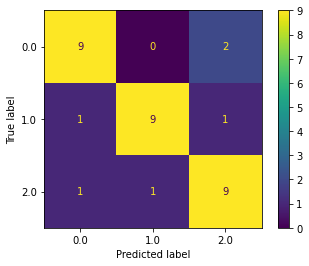

Confusion Matrix Fold 4: [[ 8  3  0]
 [ 0 10  0]
 [ 0  0 12]]
Number of Samples to be classified
Number of correct classifications 4: 0.909091


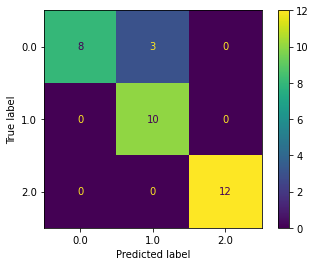

In [508]:
board_model = XGBClassifier(n_estimators = 100, max_depth = 10)
train_board_loc_classifier(board_model, X_board, y_board)

### Fit board model on full training set

In [407]:
board_model = XGBClassifier(n_estimators = 100, max_depth = 10)
board_model.fit(X_board, y_board)
board_model.save_model("xgb_board_loc.json")

## Activity Recognition 

In [164]:
data_analysis("./data/mHealth_Ex2_Data/trace_001.json")

Data Labels: {'board_loc': 1, 'path_idx': 4, 'activities': [1, 3], 'gender': 'm', 'body_height': 182, 'legi': 'ecc76'}
Data Fields:
 dict_keys(['timestamp', 'mz', 'phone_gravx', 'phone_orientationy', 'phone_ax', 'phone_orientationz', 'phone_rotz', 'altitude', 'temperature', 'phone_mx', 'gx', 'phone_az', 'phone_gy', 'gy', 'phone_lax', 'phone_rotx', 'phone_pressure', 'gz', 'lostPackets', 'phone_rotm', 'phone_mz', 'longitude', 'phone_lay', 'phone_steps', 'packetNumber', 'ax', 'phone_gx', 'phone_ay', 'phone_gravz', 'phone_roty', 'ay', 'phone_laz', 'phone_orientationx', 'bearing', 'az', 'phone_gravy', 'mx', 'phone_my', 'phone_gz', 'my', 'speed', 'latitude'])

Number of entries per field: {'timestamp': 1, 'mz': 1, 'phone_gravx': 2, 'phone_orientationy': 2, 'phone_ax': 2, 'phone_orientationz': 2, 'phone_rotz': 2, 'altitude': 1, 'temperature': 1, 'phone_mx': 2, 'gx': 16, 'phone_az': 2, 'phone_gy': 2, 'gy': 16, 'phone_lax': 2, 'phone_rotx': 2, 'phone_pressure': 0, 'gz': 16, 'lostPackets': 1, 'p

### Possible Output Activities

The output activities for this task can be the following: 
- [0] ---- [0,1] ---- [0,2] ---- [0,1,3] 
- [1] ---- [1,2] ---- [1,3] ---- [0,2,3]
- [2] ---- [2,3] ---- [0,1,2] ---[0,1,2,3]
- [3] ---- [0,3] ---- [1,2,3]

In [552]:
def rolling_window(arr: np.ndarray, window_size:int, overlap: float):
    arr = np.asarray(arr)
    overlap_step = int(overlap * window_size)
    window_step = window_size - overlap_step
    new_shape = arr.shape[:-1] + ((arr.shape[-1] - overlap_step) // window_step,
                                  window_size)
    new_strides = (arr.strides[:-1] + (window_step * arr.strides[-1],) +
                   arr.strides[-1:])
    return np.lib.stride_tricks.as_strided(arr, shape=new_shape, strides=new_strides)


def compute_basic_stats(window_array: np.ndarray):
    avg = np.average(window_array)
    std = np.std(window_array)
    median = np.median(window_array)
    fft_coefs = fft(window_array, norm = "forward")
    # print(fft_coefs.shape)
    avg_energy = np.average(np.asarray([np.sum([i**2 for i in row])/len(row) for row in fft_coefs]))
    min_max_diff = np.average(np.asarray([np.max(row)-np.min(row) for row in window_array]))
    iqr = np.average(np.asarray([np.percentile(row, 75)-np.percentile(row,25) for row in window_array]))
    rms = np.average(np.asarray([np.sqrt(np.mean([x**2 for x in row])) for row in window_array]))

    return np.asarray([avg, std, median, avg_energy, min_max_diff, iqr, rms])
        

def feature_extraction(filename):
    trace = Recording(filename, no_labels=False, mute=True)
    ax = np.asarray(trace.data["ax"].values)
    ay = np.asarray(trace.data["ay"].values)
    az = np.asarray(trace.data["az"].values)
    amag = np.sqrt(np.square(ax) + np.square(ay) + np.square(az))

    ax_windows = rolling_window(ax, 512, 0.25)
    ay_windows = rolling_window(ay, 512, 0.25)
    az_windows = rolling_window(az, 512, 0.25)
    amag_windows = rolling_window(amag, 512, 0.25)


    acc_data = [ax_windows, ay_windows, az_windows, amag_windows]
    
    feat_vector = []
    for data in acc_data:
        feat_vector.append(compute_basic_stats(data))
    return np.asarray(feat_vector).flatten().reshape(1,28)

def feature_matrix_construction(sample_folder_path):
    num_samples = len(os.listdir(sample_folder_path))
    feature_matrix = np.zeros((num_samples,28)) # Create Matrix of Row Number: Num Samples; Col Number: 20
    for idx in tqdm_notebook(range(len(os.listdir(sample_folder_path)))):
        filepath = sample_folder_path + "/" + os.listdir(sample_folder_path)[idx]
        feature_matrix[idx] = feature_extraction(filepath)
    return feature_matrix

# windows = feature_extraction("./data/pathdetection/group15_trace01.json")


In [553]:
X = feature_matrix_construction("./data/mHealth_Ex2_Data")
print(X.shape)

  0%|          | 0/167 [00:00<?, ?it/s]

/var/folders/kq/3tvn4wq14rq_ynnbrhkk02ww0000gn/T/ipykernel_34636/467619902.py:51: ComplexWarning: Casting complex values to real discards the imaginary part
  feature_matrix[idx] = feature_extraction(filepath)


(167, 28)


In [554]:
def label_vector_construction(sample_folder_path):
    num_samples = len(os.listdir(sample_folder_path))
    # feature_matrix = np.zeros((num_samples,16)) # Create Matrix of Row Number: Num Samples; Col Number: 20
    labels = []
    for idx in tqdm_notebook(range(len(os.listdir(sample_folder_path)))):
        filepath = sample_folder_path + "/" + os.listdir(sample_folder_path)[idx]
        trace = Recording(filepath, no_labels=False, mute=True)
        label = trace.labels["activities"]
        label = str(list(set(np.sort(label)))) # Remove duplicate activities and force ascending order.
        labels.append(label)
    return np.asarray(labels)

y = label_vector_construction("./data/mHealth_Ex2_Data")

  0%|          | 0/167 [00:00<?, ?it/s]

In [560]:
def encode_labels(labels:np.ndarray):
    print(np.unique(labels, return_counts=True))
    enc = LabelEncoder()
    enc.fit(labels)
    pickle.dump(enc, open("activity_encoder.pkl", 'wb'))
    labels = enc.transform(labels)
    return labels
    

y_encoded = encode_labels(np.asarray(y))


(array(['[0, 1, 2, 3]', '[0, 1, 2]', '[0, 1, 3]', '[0, 1]', '[0, 2]',
       '[1, 2]', '[1, 3]', '[1]', '[2]'], dtype='<U12'), array([ 1, 15,  2, 36,  1, 17, 11, 75,  9]))


In [561]:
def activity_detector(model, X, y):
    kfolder = KFold(n_splits = 5, shuffle = True, random_state = 0)
    idx = 0
    for train_idx, test_idx in kfolder.split(X,y):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print("Confusion Matrix Fold %d: %s"%(idx, confusion_matrix(y_test, y_pred)))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        print("Number of Samples to be classified", len(y_test))
        print("Number of correct classifications %d: %f"%(idx, accuracy_score(y_test, y_pred, normalize = True)))
        plt.show()
        idx +=1
    

Confusion Matrix Fold 0: [[ 1  0  0  0  4  0]
 [ 0  3  0  0  5  0]
 [ 0  0  0  0  4  1]
 [ 0  0  0  0  2  0]
 [ 0  0  0  0 13  0]
 [ 0  0  0  0  1  0]]
Number of Samples to be classified 34
Number of correct classifications 0: 0.500000


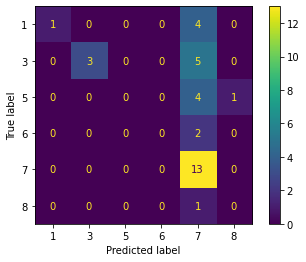

Confusion Matrix Fold 1: [[ 0  1  0  0  3  0]
 [ 0  0  0  0  7  0]
 [ 0  2  0  0  4  0]
 [ 0  1  0  0  1  0]
 [ 0  1  0  0 12  0]
 [ 0  0  0  0  1  1]]
Number of Samples to be classified 34
Number of correct classifications 1: 0.382353


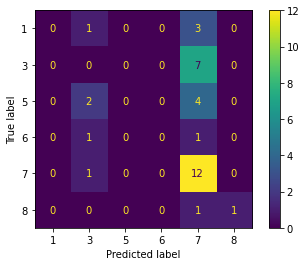

Confusion Matrix Fold 2: [[ 0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  1  0]
 [ 0  0  0  1  0  0  5  0]
 [ 0  0  0  1  0  0  3  0]
 [ 0  0  0  0  0  0  2  0]
 [ 0  0  0  3  0  0 11  0]
 [ 0  0  0  0  0  0  3  1]]
Number of Samples to be classified 33
Number of correct classifications 2: 0.393939


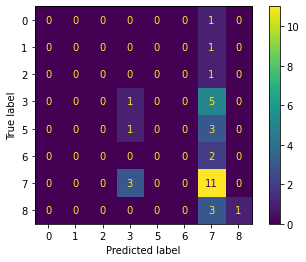

Confusion Matrix Fold 3: [[ 0  0  0  0  0  2  0]
 [ 0  0  0  0  0  1  0]
 [ 0  0  1  0  0  7  0]
 [ 0  0  0  0  0  1  0]
 [ 0  0  0  0  0  2  0]
 [ 0  0  0  0  0 17  0]
 [ 0  0  0  0  0  1  1]]
Number of Samples to be classified 33
Number of correct classifications 3: 0.575758


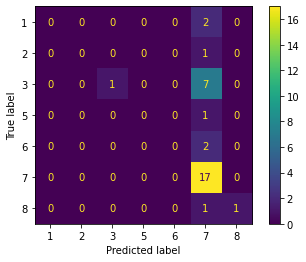

Confusion Matrix Fold 4: [[ 0  0  0  0  0  3  0]
 [ 0  3  0  0  0  4  0]
 [ 0  0  0  0  0  0  1]
 [ 0  0  0  0  0  1  0]
 [ 0  0  0  0  0  3  0]
 [ 0  2  0  0  0 16  0]
 [ 0  0  0  0  0  0  0]]
Number of Samples to be classified 33
Number of correct classifications 4: 0.575758


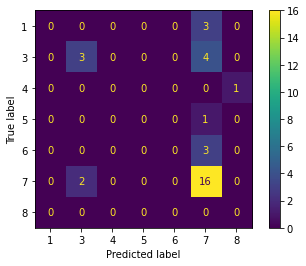

In [562]:

model_1 = ("rf", RandomForestClassifier())
model_2 = ("svm", SVC(C = 1))
model_3 = ("bernoulli", BernoulliNB())
# model = XGBClassifier()
voting_model = VotingClassifier([model_1, model_2, model_3], voting= "hard")
activity_detector(voting_model, X, y_encoded)

### Train voting model on whole dataset

In [563]:
model_1 = ("rf", RandomForestClassifier())
model_2 = ("svm", SVC(C = 1))
model_3 = ("bernoulli", BernoulliNB())

voting_model = VotingClassifier([model_1, model_2, model_3], voting= "hard")
voting_model.fit(X, y_encoded)

VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('svm', SVC(C=1)), ('bernoulli', BernoulliNB())])

In [564]:
pickle.dump(voting_model, open("activity_detector.pkl", 'wb'))

## Activity Detection - Alternative Approach

In [530]:
def train_local_activity_predictor(sample_folder_path, activity_labels_filepath):
    label_dicts = []
    with open(activity_labels_filepath) as activity_labels:
            labelled_samples = json.load(activity_labels)

    for key in labelled_samples.keys(): 
        for act_key in labelled_samples[key].keys():
            labelled_samples[key][act_key] = [j* 199 if type(j) == int else [x*199 for x in j] for j in labelled_samples[key][act_key]]  # Sampling Frequency
        label_dicts.append(labelled_samples[key])
    
    print(len(label_dicts))
    num_samples = len(os.listdir(sample_folder_path))
    # for idx in tqdm_notebook(range(len(os.listdir(sample_folder_path)))):
        
    feature_matrix = []
    label_vector = []
    window_size = 1024
    butterworth_filter = signal.butter(
            N=10, Wn=4, btype="lowpass", output="sos", fs=200
        )
    for idx in tqdm_notebook(range(len(os.listdir(sample_folder_path)))):
        filepath = sample_folder_path + "/" + os.listdir(sample_folder_path)[idx]
        trace = Recording(filepath, no_labels=False, mute=True)
        ax = np.asarray(trace.data["ax"].values)
        ay = np.asarray(trace.data["ay"].values)
        az = np.asarray(trace.data["az"].values)
        acc_mag = np.sqrt(np.square(ax) + np.square(ay) + np.square(az))
        
        first_window_idx = np.arange(0, window_size, 1, dtype = int)
        acc_mag = signal.sosfilt(butterworth_filter, acc_mag)
        mag_windows = rolling_window(acc_mag, window_size, 0.25) # Windows
        mag_window_idx = np.asarray([[j + 768*i for j in first_window_idx] for i in range(mag_windows.shape[0])]) # Sample Indexes in Windows
        for jdx, window in enumerate(mag_windows):
            first_el_idx = mag_window_idx[jdx][0]
            last_el_idx = mag_window_idx[jdx][-1]
            for label_key in label_dicts[idx].keys():
                if type(label_dicts[idx][label_key][0]) == int:
                    lower_bound = label_dicts[idx][label_key][0]
                    upper_bound = label_dicts[idx][label_key][1] +1
                    if first_el_idx in range(lower_bound,upper_bound) and last_el_idx in range(lower_bound,upper_bound):
                        feature_matrix.append(window)
                        label_vector.append(label_key)
                else:
                    for rng in label_dicts[idx][label_key]:
                        lower_bound = rng[0]
                        upper_bound = rng[1] +1
                        if first_el_idx in range(lower_bound, upper_bound) and last_el_idx in range(lower_bound, upper_bound):
                            feature_matrix.append(window)
                            label_vector.append(label_key)

    feature_matrix = np.asarray(feature_matrix)
    label_vector = np.asarray(label_vector)
    print("Windowed Feature Matrix Shape:", feature_matrix.shape)  
    print("Windowed Labels Shape:", label_vector.shape)

    return feature_matrix, label_vector

In [447]:
X_alternative, y_alternative = train_local_activity_predictor("./data/pathdetection", "activity_labels.json")

28


  0%|          | 0/28 [00:00<?, ?it/s]

Windowed Feature Matrix Shape: (2111, 1024)
Windowed Labels Shape: (2111,)


In [448]:
def train_local_activity_detector(model, X, y):
    encoding_scheme = {"s": 0,
                    "w" : 1,
                    "r" : 2,
                    "c" : 3}    
    y_alternative_enc = np.asarray([encoding_scheme[j] for j in y]) 
    activity_detector(model, X, y_alternative_enc)
    

Confusion Matrix Fold 0: [[  2  13   0   3]
 [  2 158   3   3]
 [  0  50   5   4]
 [  0  39   1  19]]
Number of Samples to be classified 302
Number of correct classifications 0: 0.609272


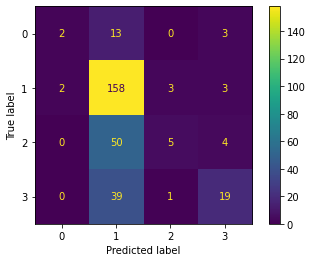

Confusion Matrix Fold 1: [[  8  15   0   2]
 [  1 146   1   5]
 [  0  54   6   1]
 [  0  56   3   4]]
Number of Samples to be classified 302
Number of correct classifications 1: 0.543046


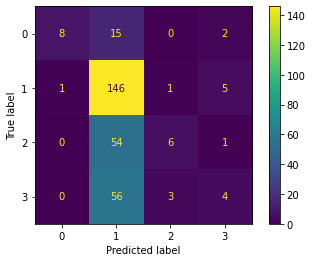

Confusion Matrix Fold 2: [[  7  14   0   5]
 [  0 138   3   7]
 [  0  45   4   6]
 [  0  49   1  23]]
Number of Samples to be classified 302
Number of correct classifications 2: 0.569536


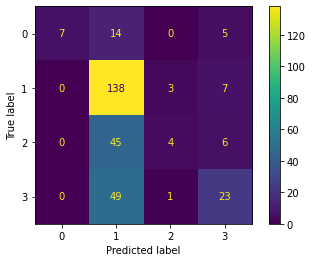

Confusion Matrix Fold 3: [[  2  10   0   2]
 [  0 132   4   5]
 [  0  74   3   0]
 [  0  64   2   4]]
Number of Samples to be classified 302
Number of correct classifications 3: 0.466887


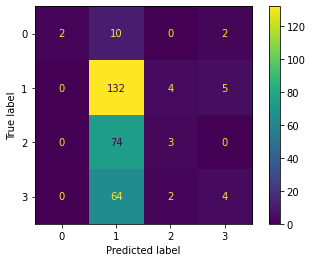

Confusion Matrix Fold 4: [[  3  14   1   3]
 [  0 137   0   8]
 [  0  55   6   7]
 [  0  44   1  22]]
Number of Samples to be classified 301
Number of correct classifications 4: 0.558140


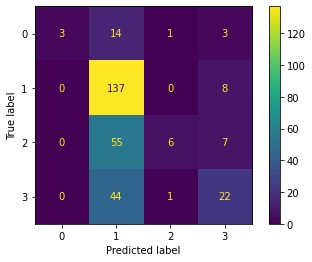

Confusion Matrix Fold 5: [[  1  13   0   3]
 [  1 147   0   8]
 [  2  43   5   4]
 [  1  53   3  17]]
Number of Samples to be classified 301
Number of correct classifications 5: 0.564784


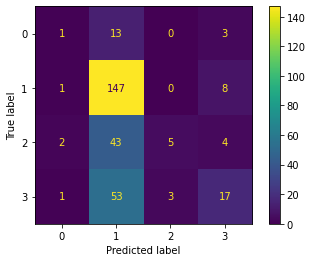

Confusion Matrix Fold 6: [[  4  11   0   1]
 [  0 145   1   3]
 [  0  66   7   3]
 [  2  42   1  15]]
Number of Samples to be classified 301
Number of correct classifications 6: 0.568106


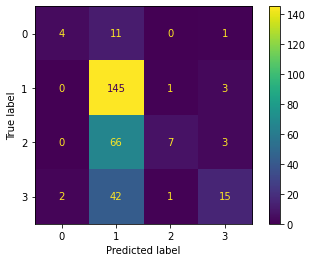

In [451]:
model_1 = ("xgb", XGBClassifier())
model_2 = ("rf", RandomForestClassifier())
model_3 = ("svm", SVC())
model_4 = ("bernoulli", BernoulliNB())

# trained_local_model = SVC(C = 1)

voting_model = VotingClassifier([model_1, model_2, model_3, model_4], voting= "hard")
train_local_activity_detector(voting_model, X_alternative, y_alternative)

#### Train Local Model on Full Dataset

In [453]:
trained_local_model = SVC(C=1)
trained_local_model.fit(X_alternative, y_alternative)


SVC(C=1)

### Create Function that takes the 

In [454]:
def assess_local_model(trained_model, sample_folder_path):
    activity_labels = []
    predicted_activities = []
    window_size = 1024
    butterworth_filter = signal.butter(
            N=6, Wn=2, btype="lowpass", output="sos", fs=200
        )
    for idx in tqdm_notebook(range(len(os.listdir(sample_folder_path)))):
        filepath = sample_folder_path + "/" + os.listdir(sample_folder_path)[idx]
        trace = Recording(filepath, no_labels=False, mute=True)
        activity_labels.append(trace.labels["activities"])
        ax = np.asarray(trace.data["ax"].values)
        ay = np.asarray(trace.data["ay"].values)
        az = np.asarray(trace.data["az"].values)
        acc_mag = np.sqrt(np.square(ax) + np.square(ay) + np.square(az))
        filtered_mag = signal.sosfilt(butterworth_filter, acc_mag)
        acc_mag = np.convolve(filtered_mag, np.ones(15) / 15, mode="full")
        mag_windows = rolling_window(acc_mag, 1024, 0.25)
        local_activity = []
        for window in mag_windows:
            out = trained_model.predict(window.reshape(1,-1))
            if out not in local_activity:
                local_activity.append(out)
        predicted_activities.append(local_activity)
    return activity_labels, predicted_activities
    
        

In [461]:
y_true, y_pred = assess_local_model(trained_local_model, "./data/mHealth_Ex2_Data")

  0%|          | 0/167 [00:00<?, ?it/s]

In [462]:
y_true_array = np.asarray(y_true)
y_pred_array = np.asarray(y_pred)

/var/folders/kq/3tvn4wq14rq_ynnbrhkk02ww0000gn/T/ipykernel_34636/2411910849.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_true_array = np.asarray(y_true)
/var/folders/kq/3tvn4wq14rq_ynnbrhkk02ww0000gn/T/ipykernel_34636/2411910849.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_pred_array = np.asarray(y_pred)


In [467]:
encoding_scheme = {"s": 0,
                    "w" : 1,
                    "r" : 2,
                    "c" : 3}  
for i in range(len(y_pred)):
    for j in range(len(y_pred[i])):
        y_pred[i][j] = encoding_scheme[y_pred[i][j][0]]


IndexError: invalid index to scalar variable.

In [471]:
y_pred = [np.sort(i) for i in y_pred_array]
y_true = [np.sort(i) for i in y_true]
print(y_true[0:15])
print(y_pred[0:15])
print(np.where(y_true == y_pred))

[array([1, 3]), array([2]), array([0, 1]), array([1]), array([1]), array([1, 2]), array([0, 1]), array([0, 1, 2]), array([0, 1]), array([1]), array([1]), array([1, 2]), array([0, 1]), array([0, 1]), array([1])]
[array([1, 2, 3]), array([1]), array([1, 2, 3]), array([1, 2]), array([1, 2, 3]), array([1, 2, 3]), array([1, 2, 3]), array([1, 3]), array([1, 3]), array([1, 3]), array([1, 3]), array([1, 2, 3]), array([1, 2, 3]), array([1, 3]), array([1, 2])]
(array([], dtype=int64),)


/var/folders/kq/3tvn4wq14rq_ynnbrhkk02ww0000gn/T/ipykernel_34636/4266453740.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(np.where(y_true == y_pred))


## Path Detection

In [498]:
def slopes(trace):
    a = trace.data['altitude'].values
    a = medfilt(a,999)
    l = len(a)
    tot = a[l-1]-a[0]
    a1 = a[int((l-1)/5)] - a[0]
    a2 = a[int(2*(l-1)/5)]- a[int((l-1)/5)]
    a3 = a[int(3*(l-1)/5)]- a[int(2*(l-1)/5)]
    a4 = a[int(4*(l-1)/5)]- a[int(3*(l-1)/5)]
    a5 = a[int(5*(l-1)/5)]- a[int(4*(l-1)/5)]
    slopes = np.array([tot,a1,a2,a3,a4,a5])
    return slopes


def feature_matrix_construction_path_detect(sample_folder_path:str):
    feature_mat = np.zeros((len(os.listdir(sample_folder_path)), 6))
    label_vector = np.zeros((len(os.listdir(sample_folder_path)),1))
    for idx in tqdm_notebook(range(len(os.listdir(sample_folder_path)))):
        filepath = sample_folder_path + "/" + os.listdir(sample_folder_path)[idx]
        trace = Recording(filepath, no_labels=False, mute=True)
        feature_mat[idx] = slopes(trace)
        label_vector[idx] = trace.labels["path_idx"]
    return feature_mat, label_vector


def train_path_detect_classifier(model, X, y):
    kfolder = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)
    idx = 0
    for train_idx, test_idx in kfolder.split(X,y):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print("Confusion Matrix Fold %d: %s"%(idx, confusion_matrix(y_test, y_pred)))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        print("Number of Samples to be classified")
        print("Number of correct classifications %d: %f"%(idx, accuracy_score(y_test, y_pred, normalize = True)))
        plt.show()
        idx +=1

In [499]:
X, y = feature_matrix_construction_path_detect("./data/mHealth_Ex2_Data")

  0%|          | 0/167 [00:00<?, ?it/s]

/Users/kevingolan/Documents/Coding_Assignments/MHAM/mham_env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kevingolan/Documents/Coding_Assignments/MHAM/mham_env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix Fold 0: [[5 2 0 0 0]
 [2 2 2 0 0]
 [3 0 3 0 0]
 [0 1 0 5 1]
 [0 0 0 1 7]]
Number of Samples to be classified
Number of correct classifications 0: 0.647059


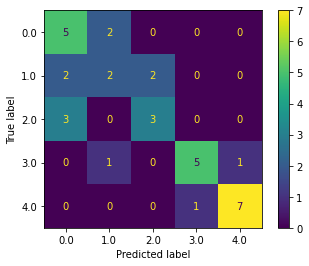

/Users/kevingolan/Documents/Coding_Assignments/MHAM/mham_env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kevingolan/Documents/Coding_Assignments/MHAM/mham_env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix Fold 1: [[4 0 3 0 0]
 [3 1 2 0 0]
 [2 0 5 0 0]
 [0 0 1 6 0]
 [0 0 0 2 5]]
Number of Samples to be classified
Number of correct classifications 1: 0.617647


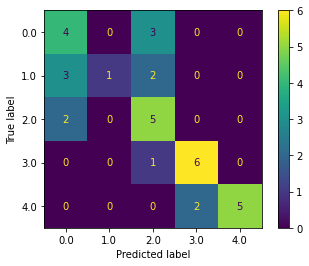

/Users/kevingolan/Documents/Coding_Assignments/MHAM/mham_env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kevingolan/Documents/Coding_Assignments/MHAM/mham_env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix Fold 2: [[3 2 1 0 0]
 [5 0 1 0 0]
 [1 2 4 0 0]
 [0 0 0 5 2]
 [0 1 0 1 5]]
Number of Samples to be classified
Number of correct classifications 2: 0.515152


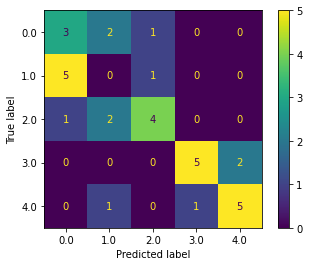

/Users/kevingolan/Documents/Coding_Assignments/MHAM/mham_env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kevingolan/Documents/Coding_Assignments/MHAM/mham_env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix Fold 3: [[5 0 1 0 0]
 [2 2 3 0 0]
 [1 0 5 0 0]
 [0 0 0 2 5]
 [0 0 0 0 7]]
Number of Samples to be classified
Number of correct classifications 3: 0.636364


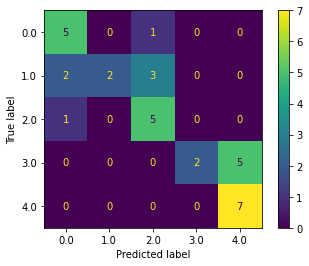

/Users/kevingolan/Documents/Coding_Assignments/MHAM/mham_env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kevingolan/Documents/Coding_Assignments/MHAM/mham_env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix Fold 4: [[4 2 1 0 0]
 [1 5 1 0 0]
 [0 2 4 0 0]
 [0 0 0 5 1]
 [0 0 0 1 6]]
Number of Samples to be classified
Number of correct classifications 4: 0.727273


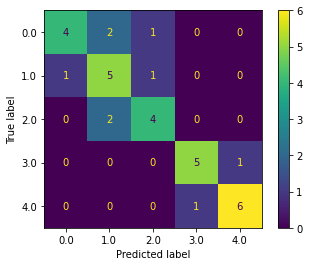

In [501]:
model_1 = ("xgb", XGBClassifier())
model_2 = ("rf", RandomForestClassifier())
model_3 = ("svm", SVC())
voting_model = VotingClassifier([model_1, model_2, model_3], voting= "hard")

train_path_detect_classifier(voting_model, X, y)


In [506]:
model_1 = ("xgb", XGBClassifier())
model_2 = ("rf", RandomForestClassifier())
model_3 = ("svm", SVC())
voting_model_path_detect = VotingClassifier([model_1, model_2, model_3], voting= "hard")
voting_model_path_detect.fit(X,y)


/Users/kevingolan/Documents/Coding_Assignments/MHAM/mham_env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kevingolan/Documents/Coding_Assignments/MHAM/mham_env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_to_onehot=None,
                                            max_d

In [507]:
pickle.dump(voting_model_path_detect, open("path_detector.pkl", 'wb'))